In [1]:
import glob
import pandas as pd
from scipy import stats
import numpy as np
import itertools

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
file_list = glob.glob('../output/*.csv')

n = len(file_list) # Número de sementes: 10 (Número de arquivos lido)
dfs = [pd.read_csv(file) for file in file_list]

df = pd.concat(dfs)
df = df[df['type'] == 'emergency_emergency']
df.head(2)

/tmp/ipykernel_77941/3566849629.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(file) for file in file_list]


,id,eclass,CO2,CO,HC,NOx,PMx,fuel,electricity,noise,...,speed,angle,x,y,seed,time,ALGORITHM,TIME_TO_BLOCK_CREATE_ACCIDENTS,TRIPS_REPETITION_RATE,SIMULATION_END_TIME
1508,veh_emergency_50.0,HBEFA3/LDV,1997.78,267.06,16.57,0.0,1.58,637.22,0.0,55.94,...,0.00,90.0,20.20,198.4,48,55.0,default,75.0,1.0,600.0
1561,veh_emergency_50.0,HBEFA3/LDV,3630.70,311.38,16.50,0.0,1.51,1153.44,0.0,67.66,...,2.45,90.0,22.65,198.4,48,56.0,default,75.0,1.0,600.0


In [3]:
lista_index = ['ALGORITHM', 'TIME_TO_BLOCK_CREATE_ACCIDENTS', 'TRIPS_REPETITION_RATE','SIMULATION_END_TIME']
var_resposta = list(set(df.columns) - set(lista_index+['id', 'eclass', 'route', 'type', 'lane', 'x', 'y', 'pos', 'time', 'angle', 'electricity']))
var_resposta

['waiting', 'seed', 'NOx', 'speed', 'noise', 'CO2', 'fuel', 'HC', 'CO', 'PMx']

In [4]:
grouped = df.drop(columns=['id', 'eclass', 'route', 'type', 'lane', 'x', 'y', 'pos', 'time', 'angle', 'electricity']).groupby(lista_index).agg(['mean','std']).reset_index()
#Cirando coluna ID para o gráfico de barra com intervalo de confiança
grouped['id'] = grouped[lista_index].apply(lambda x: '-'.join(x.astype(str)), axis=1)
grouped.sort_values(by=lista_index,ascending=[True, True,True,True], inplace=True)

grouped.head(2)

ALGORITHM TIME_TO_BLOCK_CREATE_ACCIDENTS TRIPS_REPETITION_RATE  \
                                                                   
0   default                           75.0                   1.0   
1   default                           75.0                   1.0   

  SIMULATION_END_TIME          CO2                       CO              \
                              mean          std        mean         std   
0               600.0  3337.583373  3860.234320  232.842729  205.038367   
1              1200.0  3197.605519  3735.927921  232.718657  198.715996   

          HC            ...         fuel      noise              waiting  \
        mean       std  ...          std       mean       std       mean   
0  11.515710  7.719241  ...  1222.262920  60.635184  6.953159   6.487194   
1  11.744359  7.628191  ...  1182.882197  60.194828  6.821733  22.505334   

                  speed                 seed            \
          std      mean       std       mean       std   
0   36.006405  6.446246  6.963210  46.671299  2.980819   
1  111.325803  5.870820  6.835988  46.587803  2.995066   

                        id  
                            
0   default-75.0-1.0-600.0  
1  default-75.0-1.0-1200.0  

[2 rows x 25 columns]

In [5]:
def calc_interval(grouped,var_resposta,n = 10,column_x = 'id', rotation = 0, z = stats.norm.ppf(0.975)):
    for var in var_resposta:
        #Calculo do erro médio para o intervalo de confiança
        grouped[(var, 'mean_error')] = z * (grouped[(var, 'std')] / np.sqrt(n))

In [6]:
calc_interval(grouped=grouped, var_resposta=var_resposta)

In [7]:
num_factors = len(lista_index)
factor_names = lista_index
factor_levels_real = {factor:list(grouped[factor].unique()) for factor in factor_names}
num_factors, factor_levels_real

(4,
 {'ALGORITHM': ['default', 'proposto'],
  'TIME_TO_BLOCK_CREATE_ACCIDENTS': [75.0, 150.0],
  'TRIPS_REPETITION_RATE': [1.0, 2.0],
  'SIMULATION_END_TIME': [600.0, 1200.0]})

In [8]:
num_response_vars = len(var_resposta)
response_vars_names = var_resposta
num_response_vars, response_vars_names

(10,
 ['waiting',
  'seed',
  'NOx',
  'speed',
  'noise',
  'CO2',
  'fuel',
  'HC',
  'CO',
  'PMx'])

In [10]:
# Calculating the total number of experiments
total_experiments = 2 ** num_factors
total_experiments

16

In [16]:
# Preparing the DataFrame
level_combinations = list(itertools.product([-1, 1], repeat=num_factors))
experiment_design_df = pd.DataFrame(level_combinations, columns=factor_names)
experiment_design_df.insert(0, 'Exp', range(1, len(experiment_design_df) + 1))
experiment_design_df

,Exp,ALGORITHM,TIME_TO_BLOCK_CREATE_ACCIDENTS,TRIPS_REPETITION_RATE,SIMULATION_END_TIME
0,1,-1,-1,-1,-1
1,2,-1,-1,-1,1
2,3,-1,-1,1,-1
3,4,-1,-1,1,1
4,5,-1,1,-1,-1
5,6,-1,1,-1,1
6,7,-1,1,1,-1
7,8,-1,1,1,1
8,9,1,-1,-1,-1
9,10,1,-1,-1,1


In [17]:
for var_name in response_vars_names:
    experiment_design_df[var_name] = grouped[var_name]['mean']
    experiment_design_df[var_name+'_err'] = grouped[var_name]['mean_error']
experiment_design_df

,Exp,ALGORITHM,TIME_TO_BLOCK_CREATE_ACCIDENTS,TRIPS_REPETITION_RATE,SIMULATION_END_TIME,waiting,waiting_err,seed,seed_err,NOx,...,CO2,CO2_err,fuel,fuel_err,HC,HC_err,CO,CO_err,PMx,PMx_err
0,1,-1,-1,-1,-1,6.487194,22.316591,46.671299,1.847497,0.0,...,3337.583373,2392.554055,1059.034491,757.552486,11.515710,4.784347,232.842729,127.081761,1.219832,0.567441
1,2,-1,-1,-1,1,22.505334,68.999180,46.587803,1.856327,0.0,...,3197.605519,2315.509567,1014.863693,733.144510,11.744359,4.727915,232.718657,123.163187,1.227979,0.554741
2,3,-1,-1,1,-1,0.151408,0.792043,46.427584,1.843564,0.0,...,3382.837948,2489.175956,1073.062403,788.190402,10.726856,4.966585,222.285694,133.271254,1.177164,0.597534
3,4,-1,-1,1,1,0.329966,2.083185,46.559551,1.767712,0.0,...,3398.890086,2480.534227,1078.188473,785.449075,10.871327,4.938633,224.937559,132.594018,1.184830,0.593180
4,5,-1,1,-1,-1,26.068148,42.166972,46.607362,1.793963,0.0,...,3176.971350,2240.856192,1008.495732,709.449879,12.199874,4.573717,238.282414,117.794946,1.272021,0.532556
5,6,-1,1,-1,1,107.175050,135.660824,46.804754,1.808408,0.0,...,2938.999557,2055.943411,933.482215,650.865263,12.827521,4.338131,240.731890,108.131973,1.309777,0.494772
6,7,-1,1,1,-1,0.245696,1.274879,46.378781,1.838068,0.0,...,3390.529700,2495.708549,1075.539579,790.262093,10.852099,4.981422,224.779597,133.892418,1.183525,0.597774
7,8,-1,1,1,1,19.965786,48.906081,46.499014,1.819084,0.0,...,3258.028702,2418.850224,1033.768660,765.898631,11.184868,4.922196,226.420456,129.687399,1.200772,0.582963
8,9,1,-1,-1,-1,7.664610,24.365977,46.728275,1.833059,0.0,...,3368.437809,2450.473214,1068.690953,775.900808,11.240013,4.881140,229.735873,130.403014,1.210113,0.584197
9,10,1,-1,-1,1,42.200837,85.678002,46.661985,1.791748,0.0,...,3191.839781,2309.834053,1013.040147,731.322205,11.756154,4.709891,231.812953,122.674088,1.240583,0.552681


In [18]:
# Generating interactions between factors
interaction_columns = []
for combo_length in range(2, num_factors + 1):
    for combo in itertools.combinations(factor_names, combo_length):
        interaction_name = ':'.join(combo)
        experiment_design_df[interaction_name] = np.prod(experiment_design_df[list(combo)], axis=1)
        interaction_columns.append(interaction_name)
interaction_columns

['ALGORITHM:TIME_TO_BLOCK_CREATE_ACCIDENTS',
 'ALGORITHM:TRIPS_REPETITION_RATE',
 'ALGORITHM:SIMULATION_END_TIME',
 'TIME_TO_BLOCK_CREATE_ACCIDENTS:TRIPS_REPETITION_RATE',
 'TIME_TO_BLOCK_CREATE_ACCIDENTS:SIMULATION_END_TIME',
 'TRIPS_REPETITION_RATE:SIMULATION_END_TIME',
 'ALGORITHM:TIME_TO_BLOCK_CREATE_ACCIDENTS:TRIPS_REPETITION_RATE',
 'ALGORITHM:TIME_TO_BLOCK_CREATE_ACCIDENTS:SIMULATION_END_TIME',
 'ALGORITHM:TRIPS_REPETITION_RATE:SIMULATION_END_TIME',
 'TIME_TO_BLOCK_CREATE_ACCIDENTS:TRIPS_REPETITION_RATE:SIMULATION_END_TIME',
 'ALGORITHM:TIME_TO_BLOCK_CREATE_ACCIDENTS:TRIPS_REPETITION_RATE:SIMULATION_END_TIME']

In [19]:
# Adjusting real levels in the real experiment settings
experiment_settings_real_df = experiment_design_df.copy()
for factor_name in factor_names:
    experiment_settings_real_df[factor_name] = experiment_settings_real_df[factor_name].map({-1: factor_levels_real[factor_name][0], 1: factor_levels_real[factor_name][1]})
experiment_settings_real_df

,Exp,ALGORITHM,TIME_TO_BLOCK_CREATE_ACCIDENTS,TRIPS_REPETITION_RATE,SIMULATION_END_TIME,waiting,waiting_err,seed,seed_err,NOx,...,ALGORITHM:TRIPS_REPETITION_RATE,ALGORITHM:SIMULATION_END_TIME,TIME_TO_BLOCK_CREATE_ACCIDENTS:TRIPS_REPETITION_RATE,TIME_TO_BLOCK_CREATE_ACCIDENTS:SIMULATION_END_TIME,TRIPS_REPETITION_RATE:SIMULATION_END_TIME,ALGORITHM:TIME_TO_BLOCK_CREATE_ACCIDENTS:TRIPS_REPETITION_RATE,ALGORITHM:TIME_TO_BLOCK_CREATE_ACCIDENTS:SIMULATION_END_TIME,ALGORITHM:TRIPS_REPETITION_RATE:SIMULATION_END_TIME,TIME_TO_BLOCK_CREATE_ACCIDENTS:TRIPS_REPETITION_RATE:SIMULATION_END_TIME,ALGORITHM:TIME_TO_BLOCK_CREATE_ACCIDENTS:TRIPS_REPETITION_RATE:SIMULATION_END_TIME
0,1,default,75.0,1.0,600.0,6.487194,22.316591,46.671299,1.847497,0.0,...,1,1,1,1,1,-1,-1,-1,-1,1
1,2,default,75.0,1.0,1200.0,22.505334,68.999180,46.587803,1.856327,0.0,...,1,-1,1,-1,-1,-1,1,1,1,-1
2,3,default,75.0,2.0,600.0,0.151408,0.792043,46.427584,1.843564,0.0,...,-1,1,-1,1,-1,1,-1,1,1,-1
3,4,default,75.0,2.0,1200.0,0.329966,2.083185,46.559551,1.767712,0.0,...,-1,-1,-1,-1,1,1,1,-1,-1,1
4,5,default,150.0,1.0,600.0,26.068148,42.166972,46.607362,1.793963,0.0,...,1,1,-1,-1,1,1,1,-1,1,-1
5,6,default,150.0,1.0,1200.0,107.175050,135.660824,46.804754,1.808408,0.0,...,1,-1,-1,1,-1,1,-1,1,-1,1
6,7,default,150.0,2.0,600.0,0.245696,1.274879,46.378781,1.838068,0.0,...,-1,1,1,-1,-1,-1,1,1,-1,1
7,8,default,150.0,2.0,1200.0,19.965786,48.906081,46.499014,1.819084,0.0,...,-1,-1,1,1,1,-1,-1,-1,1,-1
8,9,proposto,75.0,1.0,600.0,7.664610,24.365977,46.728275,1.833059,0.0,...,-1,-1,1,1,1,1,1,1,-1,-1
9,10,proposto,75.0,1.0,1200.0,42.200837,85.678002,46.661985,1.791748,0.0,...,-1,1,1,-1,-1,1,-1,-1,1,1


In [29]:
# Function to calculate the effects and SS
def calculate_effects_SS_dynamic(df, response_var_names):
    results = {}
    for response_var_name in response_var_names:
        n = len(df)
        response_values = df[response_var_name].values
        factor_columns = [col for col in df.columns if col not in ['Exp'] + response_var_names]
        effects = {}
        SS = {}

        for factor in factor_columns:
            factor_values = df[factor].values
            effect = np.sum(factor_values * response_values) / n
            effects[factor] = effect
            SS[factor] = n * effect ** 2

        SST = np.sum((response_values - np.mean(response_values)) ** 2)
        results[response_var_name] = (effects, SS, SST)
    return results

# Function to print formatted results
def print_formatted_results(results):
    for response_var_name, (effects, SS, SST) in results.items():
        print(f"\n{response_var_name} - Effects of Factors and Interactions:")
        for name, effect in effects.items():
            print(f"  {name}: {effect:.4f}")
        print(f"\n{response_var_name} - Sum of Squares (SS) for each Factor and Interaction:")
        for name, ss in SS.items():
            print(f"  {name}: {ss:.4f}")
        print(f"\n{response_var_name} - Total Sum of Squares (SST): {SST:.4f}")
        print(f"\n{response_var_name} - Percentage Influence of each Factor and Interaction:")
        for name, ss in SS.items():
            print(f"  {name}: {(ss / SST) * 100:.2f}%")

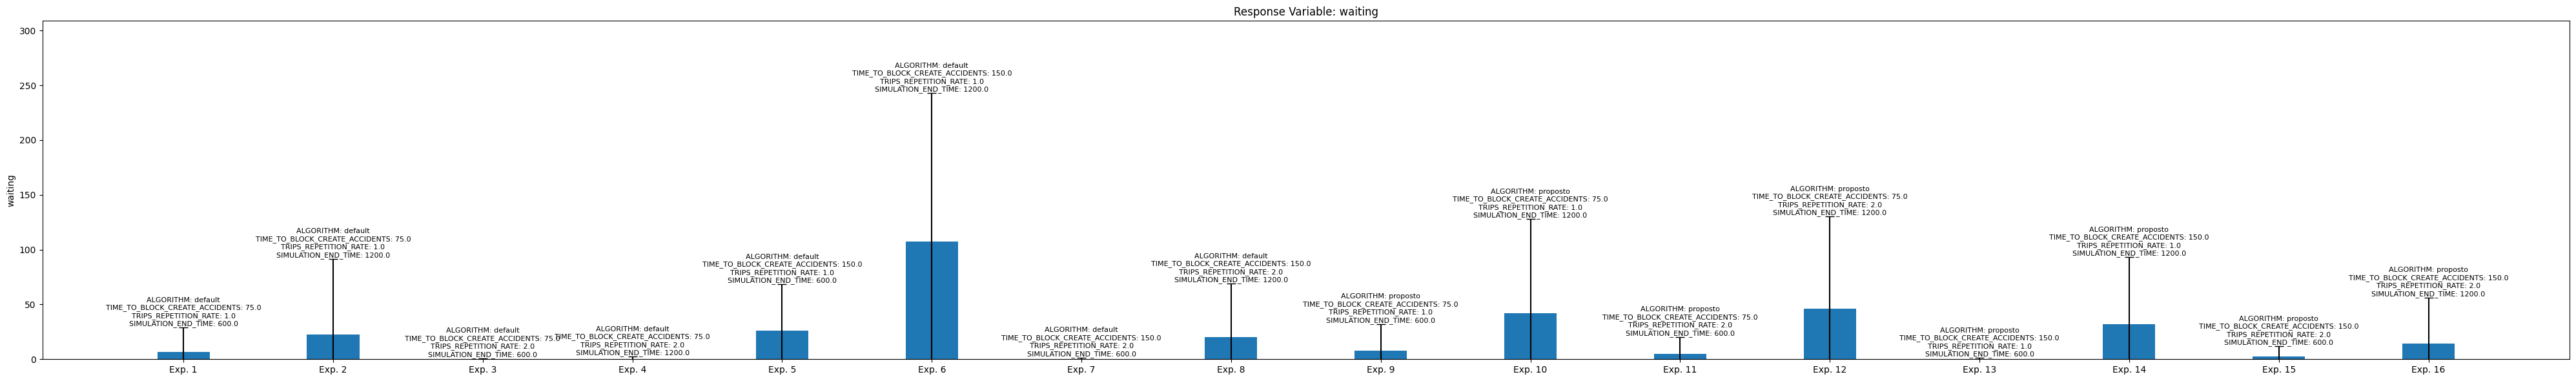

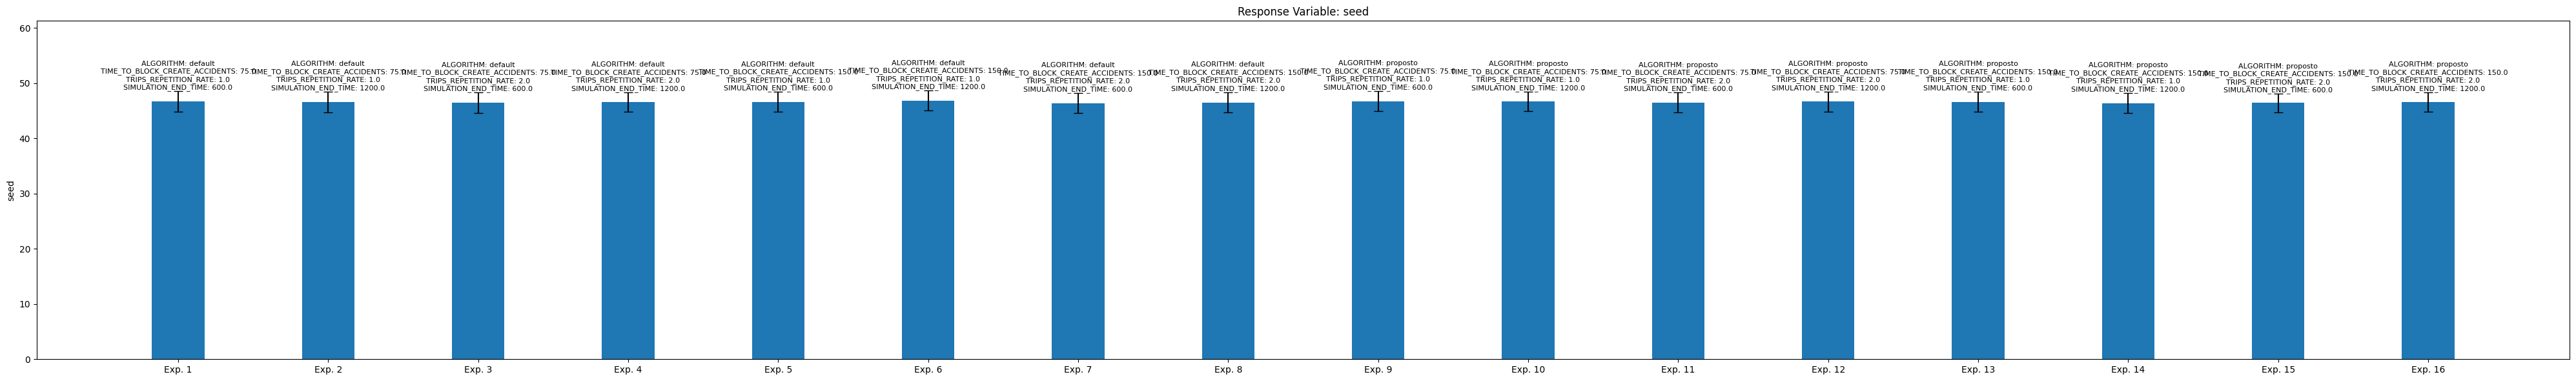

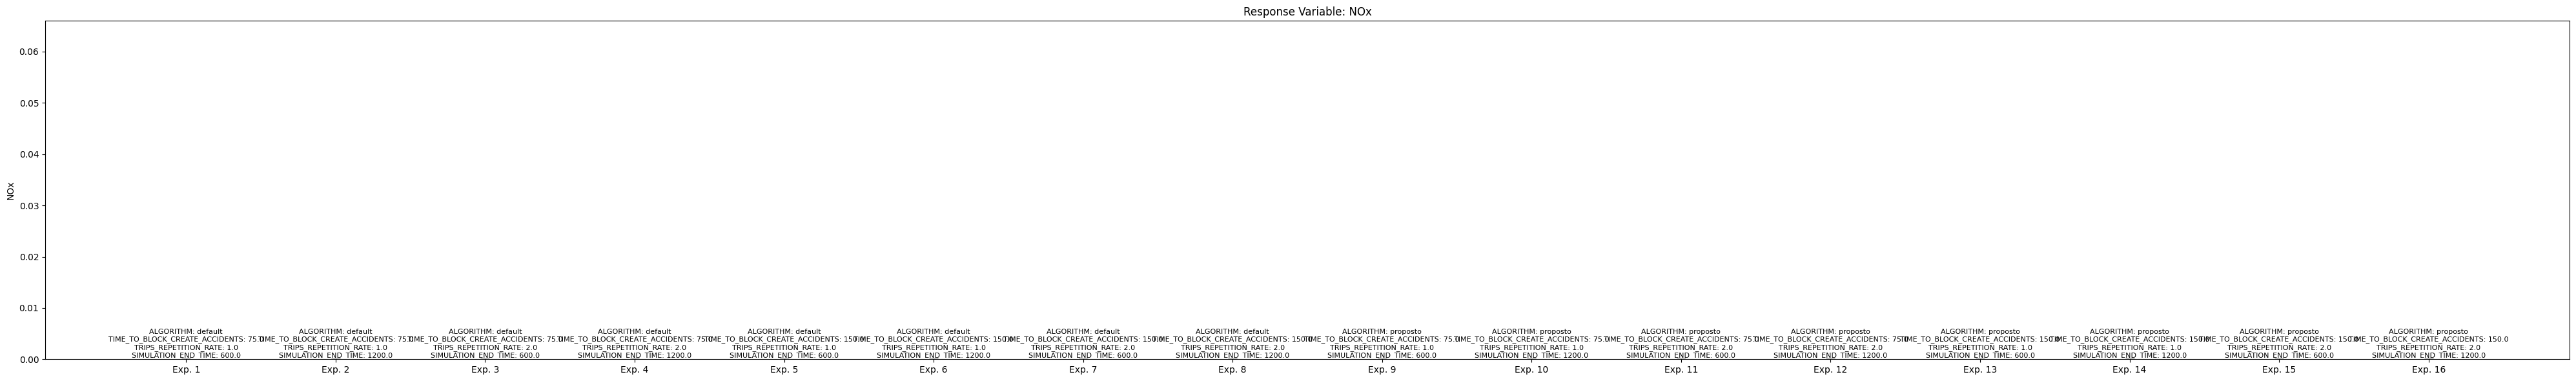

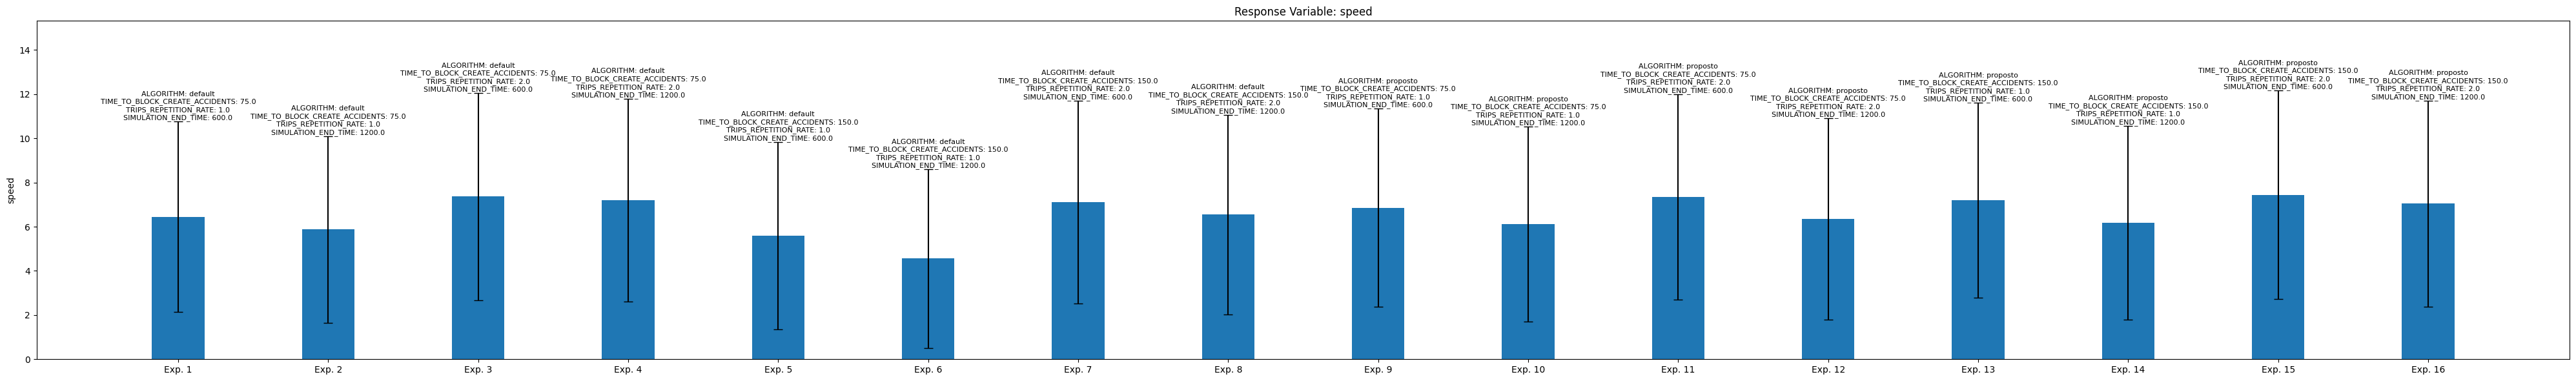

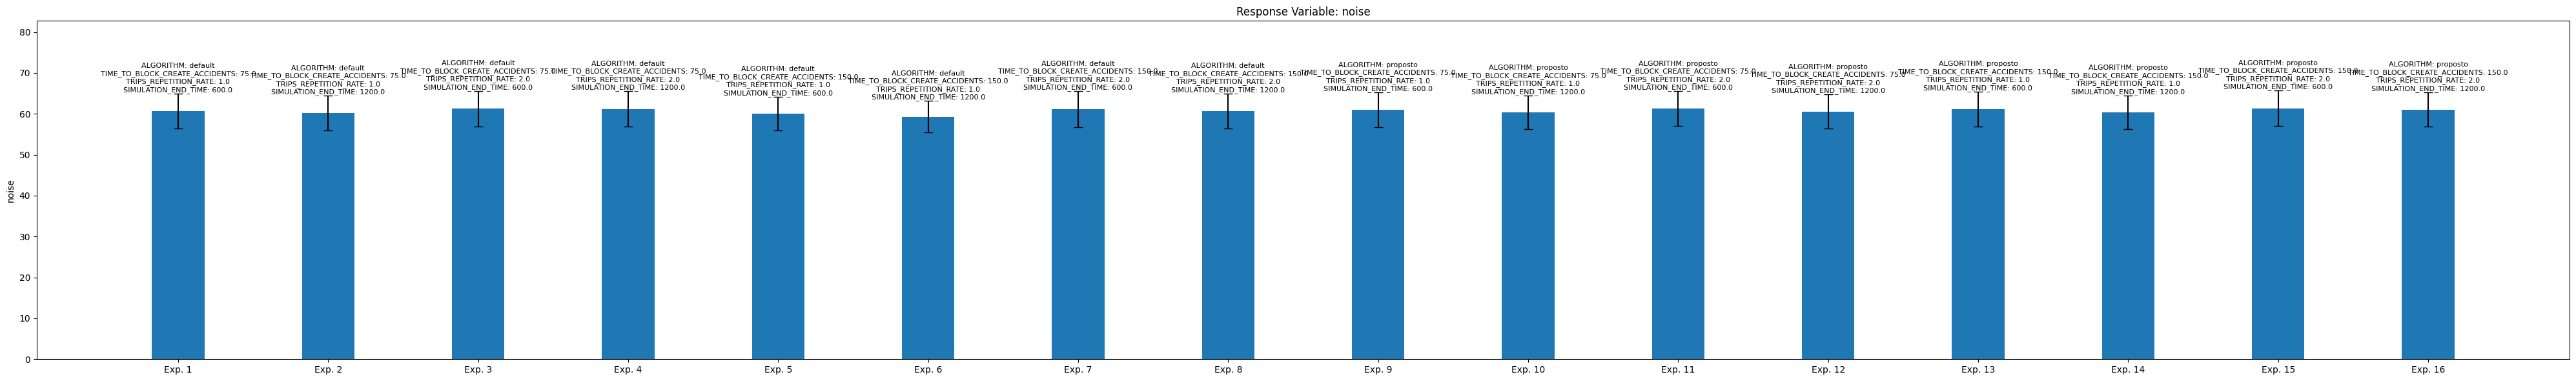

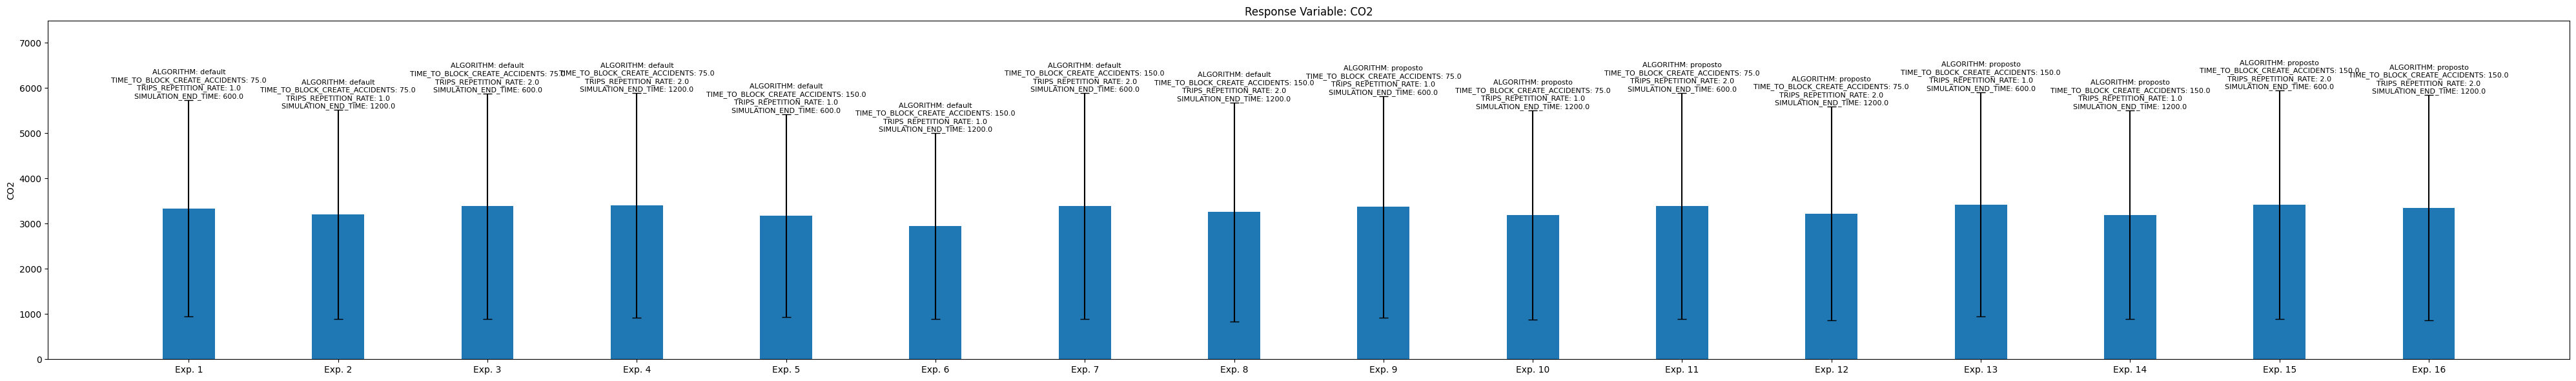

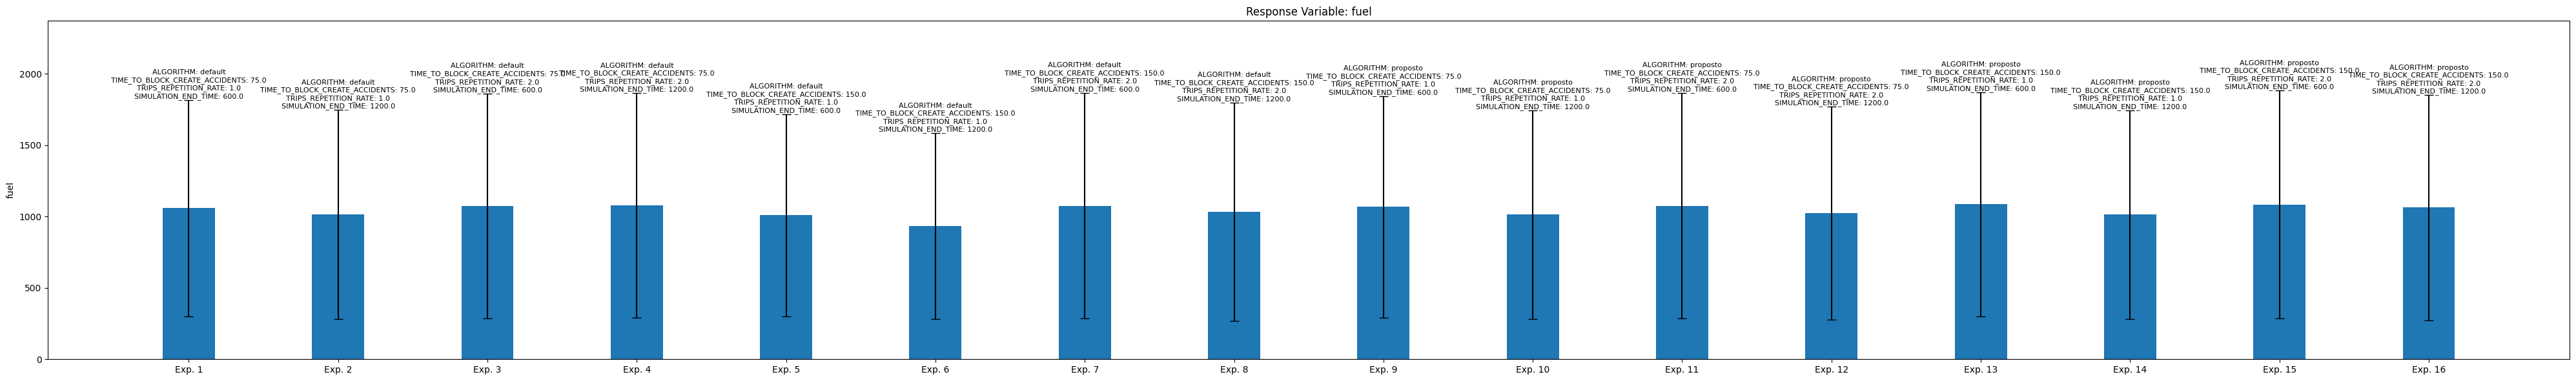

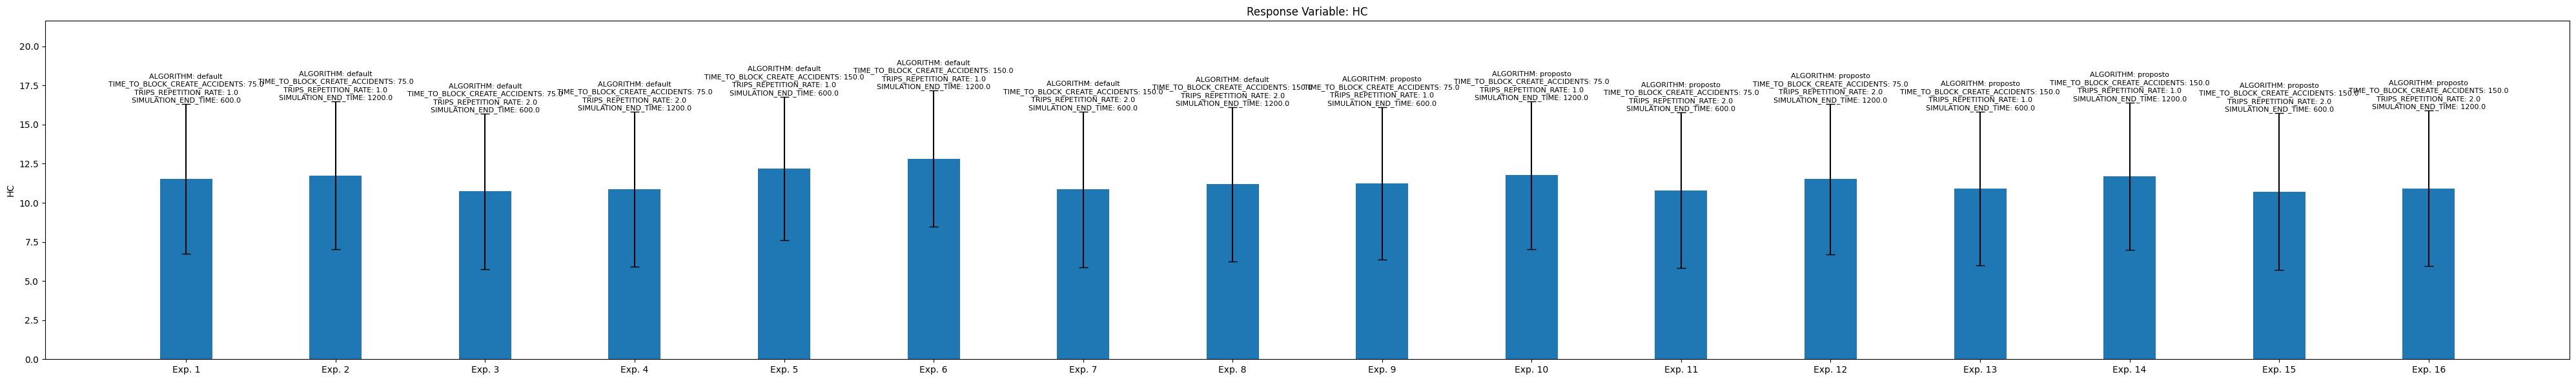

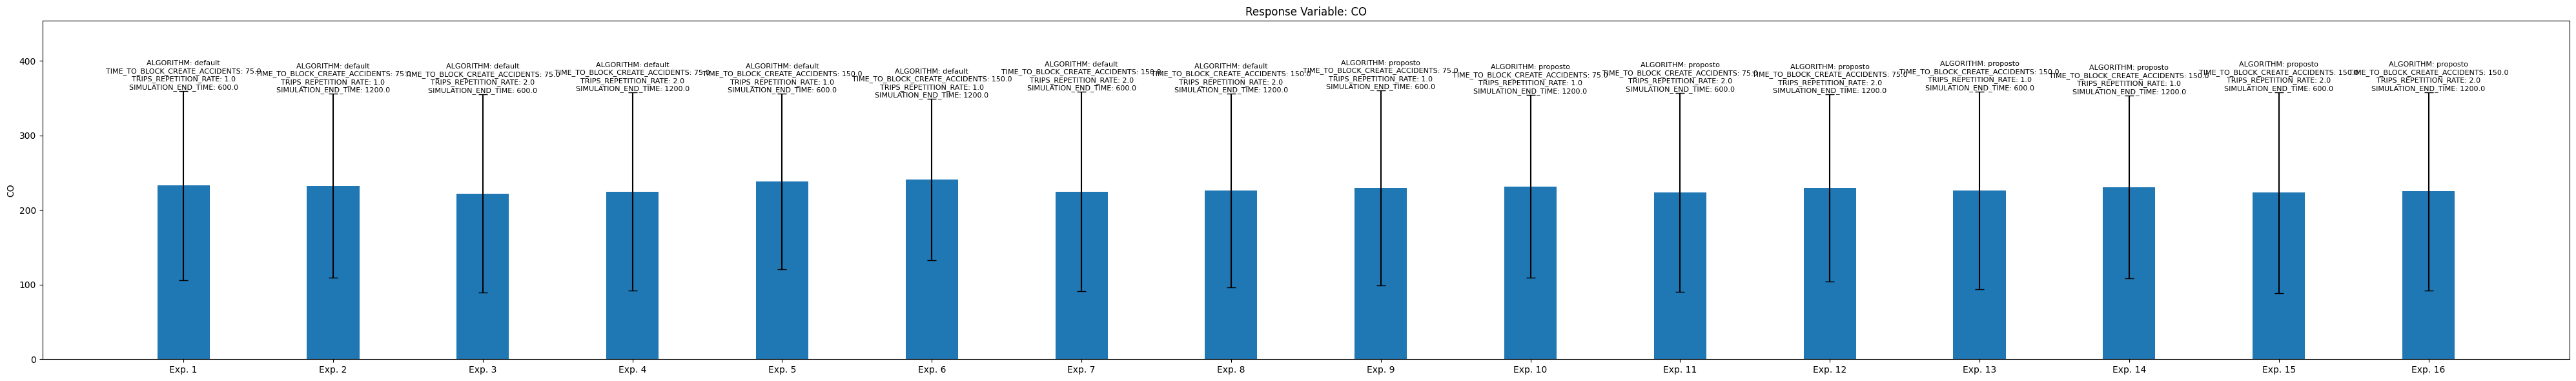

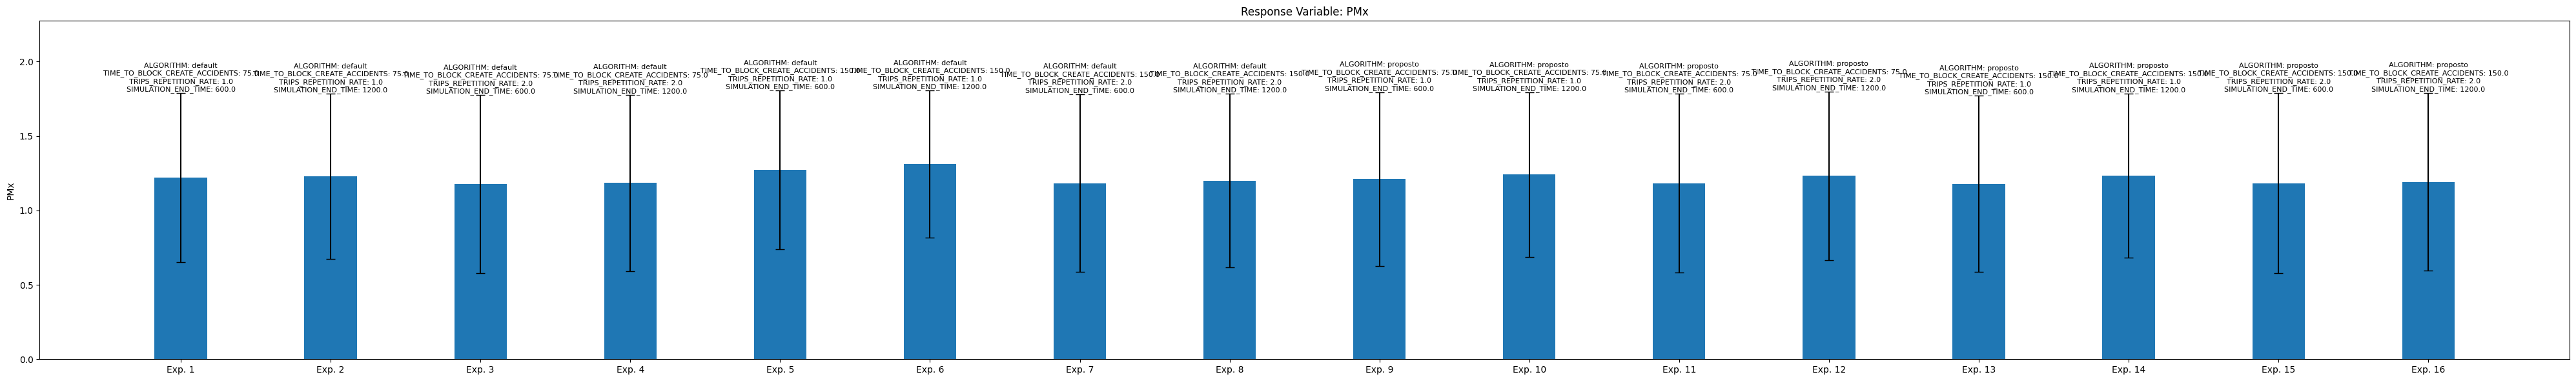

In [20]:
n_cols = 4
# Adjusting the bar width, if necessary
width = 0.35

for var_name in response_vars_names:
    # Increasing the chart height to accommodate labels
    plt.figure(figsize=(10 * n_cols, 6))  # Increasing the second value in figsize to increase the chart height
    
    n_experiments = len(experiment_settings_real_df)  # Number of experiments
    ind = np.arange(n_experiments)  # Indices for the experiments for bar positioning
    
    # Plotting the data from the real experiment settings
    bars = plt.bar(ind, experiment_settings_real_df[var_name],yerr=experiment_settings_real_df[var_name+"_err"],capsize=5,width= width, label='Experiments')
    # for i, (x_val, y_val, yerr_val) in enumerate(zip(grouped[column_x], grouped[(var, 'mean')], grouped[(var, 'mean_error')])):
    # plt.bar(x_val, y_val, yerr=yerr_val, color=colors[group_labels[i]], capsize=5)
    
    plt.title(f'Response Variable: {var_name}')  # Chart title
    plt.ylabel(var_name)  # Y-axis label
    
    # Generating labels for each bar based on factor combinations
    exp_labels = ['Exp. ' + str(exp) for exp in experiment_settings_real_df['Exp']]
    plt.xticks(ind, exp_labels)
    
    # Adding labels above bars to show factor combinations
    for bar, label in zip(bars, experiment_settings_real_df.to_dict('records')):
        height = bar.get_height()
        comb_label = '\n'.join([f"{k}: {v}" for k, v in label.items() if k in factor_names])
        height_err_plus = label[var_name+"_err"]
        plt.text(bar.get_x() + bar.get_width() / 2, height+height_err_plus, comb_label, ha='center', va='bottom', rotation=0, fontsize=8)
    
    # Adjusting the Y-axis limits to ensure labels fit without being cut off
    plt.ylim(0, plt.ylim()[1] * 1.2)  # Increases the upper limit of the Y-axis by 20%

    plt.tight_layout()
    plt.savefig('../plot/Emission_Emergency_Vehicle_Experiment/{}.pdf'.format(var_name), format='pdf')
    plt.show()
